# The Income Fluctuation Problem I: Basic Model

## Contents

- [The Income Fluctuation Problem I: Basic Model](#The-Income-Fluctuation-Problem-I:-Basic-Model)  
  - [Overview](#Overview)  
  - [The Optimal Savings Problem](#The-Optimal-Savings-Problem)  
  - [Computation](#Computation)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!conda install -y quantecon
!pip install interpolation

Solving environment: done

# All requested packages already installed.



## Overview

In this lecture, we study an optimal savings problem for an infinitely lived consumer—the “common ancestor” described in [[LS18]](https://python.quantecon.org/zreferences.html#ljungqvist2012), section 1.3.

This is an essential sub-problem for many representative macroeconomic models

- [[Aiy94]](https://python.quantecon.org/zreferences.html#aiyagari1994)  
- [[Hug93]](https://python.quantecon.org/zreferences.html#huggett1993)  
- etc.  


It is related to the decision problem in the {doc}`stochastic optimal growth model <optgrowth>` (**Issue:wrong**) (**nissue:wrong ref**) and yet differs in important ways.

For example, the choice problem for the agent includes an additive income term that leads to an occasionally binding constraint.

Moreover, in this and the following lectures, we will inject more realisitic (**Issue:realistic**)
features such as correlated shocks.

To solve the model we will use Euler equation based time iteration, which proved
to be [fast and accurate](https://python.quantecon.org/coleman_policy_iter.html) in our investigation of
the [stochastic optimal growth model](https://python.quantecon.org/optgrowth.html).

Time iteration is globally convergent under mild assumptions, even when utility is unbounded (both above and below).

We’ll need the following imports:

In [2]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain

### References

Our presentation is a simplified version of [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income).

Other references include [[Dea91]](https://python.quantecon.org/zreferences.html#deaton1991), [[DH10]](https://python.quantecon.org/zreferences.html#denhaan2010),
[[Kuh13]](https://python.quantecon.org/zreferences.html#kuhn2013), [[Rab02]](https://python.quantecon.org/zreferences.html#rabault2002),  [[Rei09]](https://python.quantecon.org/zreferences.html#reiter2009)  and
[[SE77]](https://python.quantecon.org/zreferences.html#schechtmanescudero1977).

## The Optimal Savings Problem


<a id='index-1'></a>
Let’s write down the model and then discuss how to solve it.

### Set-Up

Consider a household that chooses a state-contingent consumption plan $ \{c_t\}_{t \geq 0} $ to maximize

$$
\mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to


<a id='equation-eqst'></a>
$$
a_{t+1} \leq  R(a_t - c_t)  + Y_{t+1},
\quad c_t \geq 0,
\quad a_t \geq 0
\quad t = 0, 1, \ldots \tag{1}
$$

Here

- $ \beta \in (0,1) $ is the discount factor  
- $ a_t $ is asset holdings at time $ t $, with borrowing constraint $ a_t \geq 0 $  
- $ c_t $ is consumption  
- $ Y_t $ is non-capital income (wages, unemployment compensation, etc.)  
- $ R := 1 + r $, where $ r > 0 $ is the interest rate on savings  


The timing here is as follows:

1. At the start of period $ t $, the household chooses consumption
  $ c_t $.  
1. Labor is supplied by the household throughout the period and labor income
  $ Y_{t+1} $ is received at the end of period $ t $.  
1. Financial income $ R(a_t - c_t) $ is received at the end of period $ t $.  
1. Time shifts to $ t+1 $ and the process repeats.  


Non-capital income $ Y_t $ is given by $ Y_t = y(Z_t) $, where
$ \{Z_t\} $ is an exogeneous state process.

As is common in the literature, we take $ \{Z_t\} $ to be a finite state
Markov chain taking values in $ \mathsf Z $ with Markov matrix $ P $.

We further assume that (**nissue:math processing error**)

1. $ \beta R < 1 $  
1. $ u $ is smooth, strictly increasing and strictly concave with $ \lim_{c \to 0} u'(c) = \infty $ and $ \lim_{c \to \infty} u'(c) = 0 $  


The asset space is $ \mathbb R_+ $ and the state is the pair $ (a,z)
\in \mathsf S := \mathbb R_+ \times \mathsf Z $.

A *feasible consumption path* from $ (a,z) \in \mathsf S $ is a consumption
sequence $ \{c_t\} $ such that $ \{c_t\} $ and its induced asset path $ \{a_t\} $ satisfy

1. $ (a_0, z_0) = (a, z) $  
1. the feasibility constraints in [(34.1)](#equation-eqst), and  
1. measurability, which means that $ c_t $ is a function of random
  outcomes up to date $ t $ but not after.  


The meaning of the third point is just that consumption at time $ t $
cannot be a function of outcomes are yet to be observed.

In fact, for this problem, consumption can be chosen optimally by taking it to
be contingent only on the current state.

Optimality is defined below.

### Value Function and Euler Equation

The *value function* $ V \colon \mathsf S \to \mathbb{R} $ is defined by


<a id='equation-eqvf'></a>
$$
V(a, z) := \max \, \mathbb{E}
\left\{
\sum_{t=0}^{\infty} \beta^t u(c_t)
\right\} \tag{2}
$$

where the maximization is overall feasible consumption paths from $ (a,z) $.

An *optimal consumption path* from $ (a,z) $ is a feasible consumption path from $ (a,z) $ that attains the supremum in [(34.2)](#equation-eqvf).

To pin down such paths we can use a version of the Euler equation, which in the present setting is


<a id='equation-ee00'></a>
$$
u' (c_t)
\geq \beta R \,  \mathbb{E}_t  u'(c_{t+1}) \tag{3}
$$

and


<a id='equation-ee01'></a>
$$
c_t < a_t
\; \implies \;
u' (c_t) = \beta R \,  \mathbb{E}_t  u'(c_{t+1}) \tag{4}
$$

When $ c_t = a_t $ we obviously have $ u'(c_t) = u'(a_t) $,

When $ c_t $ hits the upper bound $ a_t $, the
strict inequality $ u' (c_t) > \beta R \,  \mathbb{E}_t  u'(c_{t+1}) $
can occur because $ c_t $ cannot increase sufficiently to attain equality.

(The lower boundary case $ c_t = 0 $ never arises at the optimum because
$ u'(0) = \infty $(**Issue:.**))

With some thought, one can show that [(34.3)](#equation-ee00) and [(34.4)](#equation-ee01) are
equivalent to


<a id='equation-eqeul0'></a>
$$
u' (c_t)
= \max \left\{
    \beta R \,  \mathbb{E}_t  u'(c_{t+1})  \,,\;  u'(a_t)
\right\} \tag{5}
$$

### Optimality Results

As shown in [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income),

1. For each $ (a,z) \in \mathsf S $, a unique optimal consumption path from $ (a,z) $ exists  
1. This path is the unique feasible path from $ (a,z) $ satisfying the
  Euler equality [(34.5)](#equation-eqeul0) and the transversality condition  



<a id='equation-eqtv'></a>
$$
\lim_{t \to \infty} \beta^t \, \mathbb{E} \, [ u'(c_t) a_{t+1} ] = 0 \tag{6}
$$

Moreover, there exists an *optimal consumption function*
$ \sigma^* \colon \mathsf S \to \mathbb R_+ $ such that the path
from $ (a,z) $ generated by

$$
(a_0, z_0) = (a, z),
\quad
c_t = \sigma^*(a_t, Z_t)
\quad \text{and} \quad
a_{t+1} = R (a_t - c_t) + Y_{t+1}
$$

satisfies both [(34.5)](#equation-eqeul0) and [(34.6)](#equation-eqtv), and hence is the unique optimal
path from $ (a,z) $.

Thus, to solve the optimization problem, we need to compute the policy $ \sigma^* $.


<a id='ifp-computation'></a>

## Computation


<a id='index-2'></a>
There are two standard ways to solve for $ \sigma^* $

1. time iteration using the Euler equality and  
1. value function iteration.  


Our investigation of the cake eating problem and stochastic optimal growth
model suggests that time iteration will be faster and more accurate.

This is the approach that we apply below.

### Time Iteration

We can rewrite [(34.5)](#equation-eqeul0) to make it a statement about functions rather than
random variables.

In particular, consider the functional equation


<a id='equation-eqeul1'></a>
$$
(u' \circ \sigma)  (a, z)
= \max \left\{
\beta R \, \mathbb E_z (u' \circ \sigma)
    [R (a - \sigma(a, z)) + \hat Y, \, \hat Z]
\, , \;
     u'(a)
     \right\} \tag{7}
$$

where

- $ (u' \circ \sigma)(s) := u'(\sigma(s)) $.  
- $ \mathbb E_z $ conditions on current state $ z $ and $ \hat X $
  indicates next period value of random variable $ X $ and  
- $ \sigma $ is the unknown function.  


We need a suitable class of candidate solutions for the optimal consumption
policy.

The right way to pick such a class is to consider what properties the solution
is likely to have, in order to restrict the search space and ensure that
iteration is well behaved.

To this end, let $ \mathscr C $ be the space of continuous functions $ \sigma \colon \mathbf S \to \mathbb R $ such that $ \sigma $ is increasing in the first argument, $ 0 < \sigma(a,z) \leq a $ for all $ (a,z) \in \mathbf S $, and


<a id='equation-ifpc4'></a>
$$
\sup_{(a,z) \in \mathbf S}
\left| (u' \circ \sigma)(a,z) - u'(a) \right| < \infty \tag{8}
$$

This will be our candidate class.

In addition, let $ K \colon \mathscr{C} \to \mathscr{C} $ be defined as
follows.

For given $ \sigma \in \mathscr{C} $, the value $ K \sigma (a,z) $ is the unique $ c \in [0, a] $ that solves


<a id='equation-eqsifc'></a>
$$
u'(c)
= \max \left\{
           \beta R \, \mathbb E_z (u' \circ \sigma) \,
           [R (a - c) + \hat Y, \, \hat Z]
           \, , \;
           u'(a)
     \right\} \tag{9}
$$

We refer to $ K $ as the Coleman–Reffett operator.

The operator $ K $ is constructed so that fixed points of $ K $
coincide with solutions to the functional equation [(34.7)](#equation-eqeul1).

It is shown in [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income) that the unique optimal policy can be
computed by picking any $ \sigma \in \mathscr{C} $ and iterating with the
operator $ K $ defined in [(34.9)](#equation-eqsifc).

### Some Technical Details

The proof of the last statement is somewhat technical but here is a quick
summary:(**Issue:.**)

It is shown in [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income) that $ K $ is a contraction mapping on
$ \mathscr{C} $ under the metric

$$
\rho(c, d) := \| \, u' \circ \sigma_1 - u' \circ \sigma_2 \, \|
    := \sup_{s \in S} | \, u'(\sigma_1(s))  - u'(\sigma_2(s)) \, |
 \qquad \quad (\sigma_1, \sigma_2 \in \mathscr{C})
$$

which evaluates the maximal difference in terms of marginal utility.

(The benefit of this measure of distance is that, while elements of $ \mathscr C $ are not generally bounded, $ \rho $ is always finite under our assumptions.)

It is also shown that the metric $ \rho $ is complete on $ \mathscr{C} $.

In consequence, $ K $ has a unique fixed point $ \sigma^* \in \mathscr{C} $ and $ K^n c \to \sigma^* $ as $ n \to \infty $ for any $ \sigma \in \mathscr{C} $.

By the definition of $ K $, the fixed points of $ K $ in $ \mathscr{C} $ coincide with the solutions to [(34.7)](#equation-eqeul1) in $ \mathscr{C} $.

As a consequence, the path $ \{c_t\} $ generated from $ (a_0,z_0) \in
S $ using policy function $ \sigma^* $ is the unique optimal path from
$ (a_0,z_0) \in S $.

## Implementation


<a id='index-3'></a>
We use the CRRA utility specification

$$
u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$

The exogeneous state process $ \{Z_t\} $ defaults to a two-state Markov chain
with state space $ \{0, 1\} $ and transition matrix $ P $.

Here we build a class called `IFP` that stores the model primitives.

In [3]:
ifp_data = [
    ('R', float64),              # Interest rate 1 + r
    ('β', float64),              # Discount factor
    ('γ', float64),              # Preference parameter
    ('P', float64[:, :]),        # Markov matrix for binary Z_t
    ('y', float64[:]),           # Income is Y_t = y[Z_t]
    ('asset_grid', float64[:])   # Grid (array)
]

@jitclass(ifp_data)
class IFP:

    def __init__(self,
                 r=0.01,
                 β=0.96,
                 γ=1.5,
                 P=((0.6, 0.4),
                    (0.05, 0.95)),
                 y=(0.0, 2.0),
                 grid_max=16,
                 grid_size=50):

        self.R = 1 + r
        self.β, self.γ = β, γ
        self.P, self.y = np.array(P), np.array(y)
        self.asset_grid = np.linspace(0, grid_max, grid_size)

        # Recall that we need R β < 1 for convergence.
        assert self.R * self.β < 1, "Stability condition violated."

    def u_prime(self, c):
        return c**(-self.γ)

Next we provide a function to compute the difference


<a id='equation-euler-diff-eq'></a>
$$
u'(c)
- \max \left\{
           \beta R \, \mathbb E_z (u' \circ \sigma) \,
           [R (a - c) + \hat Y, \, \hat Z]
           \, , \;
           u'(a)
     \right\} \tag{10}
$$

In [4]:
@njit
def euler_diff(c, a, z, σ_vals, ifp):
    """
    The difference between the left- and right-hand side
    of the Euler Equation, given current policy σ.

        * c is the consumption choice
        * (a, z) is the state, with z in {0, 1}
        * σ_vals is a policy represented as a matrix.
        * ifp is an instance of IFP

    """

    # Simplify names
    R, P, y, β, γ  = ifp.R, ifp.P, ifp.y, ifp.β, ifp.γ
    asset_grid, u_prime = ifp.asset_grid, ifp.u_prime
    n = len(P)

    # Convert policy into a function by linear interpolation
    def σ(a, z):
        return interp(asset_grid, σ_vals[:, z], a)

    # Calculate the expectation conditional on current z
    expect = 0.0
    for z_hat in range(n):
        expect += u_prime(σ(R * (a - c) + y[z_hat], z_hat)) * P[z, z_hat]

    return u_prime(c) - max(β * R * expect, u_prime(a))

Note that we use linear interpolation along the asset grid to approximate the
policy function.

The next step is to obtain the root of the Euler difference.

In [5]:
@njit
def K(σ, ifp):
    """
    The operator K.

    """
    σ_new = np.empty_like(σ)
    for i, a in enumerate(ifp.asset_grid):
        for z in (0, 1):
            result = brentq(euler_diff, 1e-8, a, args=(a, z, σ, ifp))
            σ_new[i, z] = result.root

    return σ_new

With the operator $ K $ in hand, we can choose an initial condition and
start to iterate.

The following function iterates to convergence and returns the approximate
optimal policy. (**Issue: weird code cell in myst**)

In [6]:
def solve_model_time_iter(model,    # Class with model information
                          σ,        # Initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

Let’s carry this out using the default parameters of the `IFP` class:

In [7]:
ifp = IFP()

# Set up initial consumption policy of consuming all assets at all z
z_size = len(ifp.P)
a_grid = ifp.asset_grid
a_size = len(a_grid)
σ_init = np.repeat(a_grid.reshape(a_size, 1), z_size, axis=1)

σ_star = solve_model_time_iter(ifp, σ_init)

Error at iteration 25 is 0.011629589188246303.
Error at iteration 50 is 0.0003857183099467143.

Converged in 60 iterations.


Here’s a plot of the resulting policy for each exogeneous state $ z $.

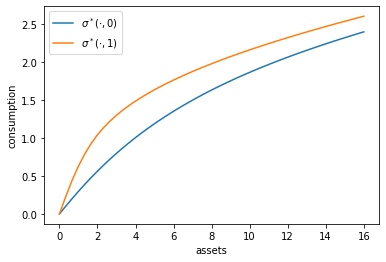

In [8]:
fig, ax = plt.subplots()
for z in range(z_size):
    label = rf'$\sigma^*(\cdot, {z})$'
    ax.plot(a_grid, σ_star[:, z], label=label)
ax.set(xlabel='assets', ylabel='consumption')
ax.legend()
plt.show()

The following exercises walk you through several applications where policy functions are computed.

### A Sanity Check

One way to check our results is to

- set labor income to zero in each state and  
- set the gross interest rate $ R $ to unity.  


In this case, our income fluctuation problem is just a cake eating problem.

We know that, in this case, the value function and optimal consumption policy
are given by (**Issue: weird code cell in myst**)

In [9]:
def c_star(x, β, γ):

    return (1 - β ** (1/γ)) * x


def v_star(x, β, γ):

    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

Let’s see if we match up:

Error at iteration 25 is 0.023332272630545492.
Error at iteration 50 is 0.005301238424249566.
Error at iteration 75 is 0.0019706324625650695.
Error at iteration 100 is 0.0008675521337956349.
Error at iteration 125 is 0.00041073542212255454.
Error at iteration 150 is 0.00020120334010526042.
Error at iteration 175 is 0.00010021430795065234.

Converged in 176 iterations.


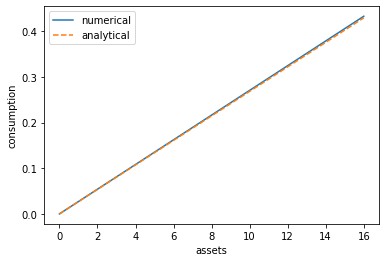

In [10]:
ifp_cake_eating = IFP(r=0.0, y=(0.0, 0.0))

σ_star = solve_model_time_iter(ifp_cake_eating, σ_init)

fig, ax = plt.subplots()
ax.plot(a_grid, σ_star[:, 0], label='numerical')
ax.plot(a_grid, c_star(a_grid, ifp.β, ifp.γ), '--', label='analytical')

ax.set(xlabel='assets', ylabel='consumption')
ax.legend()

plt.show() # (**Issue: no prints in myst**)

Success!

## Exercises

### Exercise 1

Let’s consider how the interest rate affects consumption.

Reproduce the following figure, which shows (approximately) optimal consumption policies for different interest rates

![https://python.quantecon.org/_static/lecture_specific/ifp/ifp_policies.png](https://python.quantecon.org/_static/lecture_specific/ifp/ifp_policies.png)

  
- Other than `r`, all parameters are at their default values.  
- `r` steps through `np.linspace(0, 0.04, 4)`.  
- Consumption is plotted against assets for income shock fixed at the smallest value.  


The figure shows that higher interest rates boost savings and hence suppress consumption.


<a id='ifp-lrex'></a>

### Exercise 2

Now let’s consider the long run asset levels held by households under the
default parameters.

The following figure is a 45 degree diagram showing the law of motion for assets when consumption is optimal

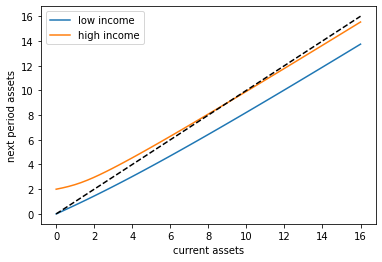

In [11]:
ifp = IFP()

σ_star = solve_model_time_iter(ifp, σ_init, verbose=False)
a = ifp.asset_grid
R, y = ifp.R, ifp.y

fig, ax = plt.subplots()
for z, lb in zip((0, 1), ('low income', 'high income')):
    ax.plot(a, R * (a - σ_star[:, z]) + y[z] , label=lb)

ax.plot(a, a, 'k--')
ax.set(xlabel='current assets', ylabel='next period assets')

ax.legend()
plt.show() # (**Issue: no prints in myst**)

The unbroken lines show the update function for assets at each $ z $, which is

$$
a \mapsto R (a - \sigma^*(a, z)) + y(z)
$$

The dashed line is the 45 degree line.

We can see from the figure that the dynamics will be stable — assets do not
diverge even in the highest state.

In fact there is a unique stationary distribution of assets that we can calculate by simulation

- Can be proved via theorem 2 of [[HP92]](https://python.quantecon.org/zreferences.html#hopenhaynprescott1992).  
- It represents the long run dispersion of assets across households when households have idiosyncratic shocks.  


Ergodicity is valid here, so stationary probabilities can be calculated by averaging over a single long time series.

Hence to approximate the stationary distribution we can simulate a long time
series for assets and histogram it.

Your task is to generate such a histogram.

- Use a single time series $ \{a_t\} $ of length 500,000.  
- Given the length of this time series, the initial condition $ (a_0,
  z_0) $ will not matter.  
- You might find it helpful to use the `MarkovChain` class from `quantecon`.  

### Exercise 3

Following on from exercises 1 and 2, let’s look at how savings and aggregate
asset holdings vary with the interest rate

- Note: [[LS18]](https://python.quantecon.org/zreferences.html#ljungqvist2012) section 18.6 can be consulted for more
  background on the topic treated in this exercise.  


For a given parameterization of the model, the mean of the stationary
distribution of assets can be interpreted as aggregate capital in an economy
with a unit mass of *ex-ante* identical households facing idiosyncratic
shocks.

Your task is to investigate how this measure of aggregate capital varies with
the interest rate.

Following tradition, put the price (i.e., interest rate) is (**Issue: delete ``is``**) on the vertical axis.

On the horizontal axis put aggregate capital, computed as the mean of the
stationary distribution given the interest rate.

## Solutions

### Exercise 1

Here’s one solution:

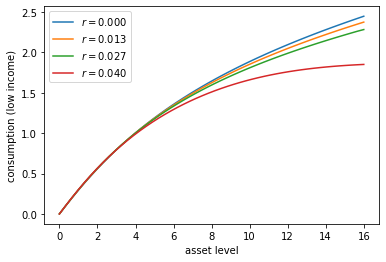

In [12]:
r_vals = np.linspace(0, 0.04, 4)

fig, ax = plt.subplots()
for r_val in r_vals:
    ifp = IFP(r=r_val)
    σ_star = solve_model_time_iter(ifp, σ_init, verbose=False)
    ax.plot(ifp.asset_grid, σ_star[:, 0], label=f'$r = {r_val:.3f}$')

ax.set(xlabel='asset level', ylabel='consumption (low income)')
ax.legend()
plt.show() # (**Issue: no prints in myst**)

### Exercise 2

First we write a function to compute a long asset series.

In [13]:
def compute_asset_series(ifp, T=500_000, seed=1234):
    """
    Simulates a time series of length T for assets, given optimal
    savings behavior.

    ifp is an instance of IFP
    """
    P, y, R = ifp.P, ifp.y, ifp.R  # Simplify names

    # Solve for the optimal policy
    σ_star = solve_model_time_iter(ifp, σ_init, verbose=False)
    σ = lambda a, z: interp(ifp.asset_grid, σ_star[:, z], a)

    # Simulate the exogeneous state process
    mc = MarkovChain(P)
    z_seq = mc.simulate(T, random_state=seed)

    # Simulate the asset path
    a = np.zeros(T+1)
    for t in range(T):
        z = z_seq[t]
        a[t+1] = R * (a[t] - σ(a[t], z)) + y[z]
    return a

Now we call the function, generate the series and then histogram it:

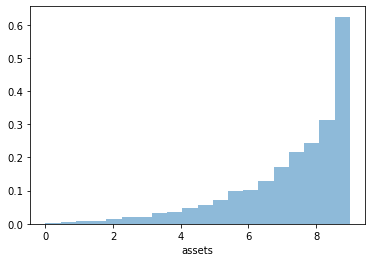

In [14]:
ifp = IFP()
a = compute_asset_series(ifp)

fig, ax = plt.subplots()
ax.hist(a, bins=20, alpha=0.5, density=True)
ax.set(xlabel='assets')
plt.show() # (**Issue: no prints in myst**)

The shape of the asset distribution is unrealistic.

Here it is left skewed when in reality it has a long right tail.

In a [subsequent lecture](https://python.quantecon.org/ifp_advanced.html) we will rectify this by adding
more realistic features to the model.

### Exercise 3

Here’s one solution

Solving model at r = 0.0
Solving model at r = 0.0008333333333333334
Solving model at r = 0.0016666666666666668
Solving model at r = 0.0025
Solving model at r = 0.0033333333333333335
Solving model at r = 0.004166666666666667
Solving model at r = 0.005
Solving model at r = 0.005833333333333334
Solving model at r = 0.006666666666666667
Solving model at r = 0.007500000000000001
Solving model at r = 0.008333333333333333
Solving model at r = 0.009166666666666667
Solving model at r = 0.01
Solving model at r = 0.010833333333333334
Solving model at r = 0.011666666666666667
Solving model at r = 0.0125
Solving model at r = 0.013333333333333334
Solving model at r = 0.014166666666666668
Solving model at r = 0.015000000000000001
Solving model at r = 0.015833333333333335
Solving model at r = 0.016666666666666666
Solving model at r = 0.0175
Solving model at r = 0.018333333333333333
Solving model at r = 0.01916666666666667
Solving model at r = 0.02


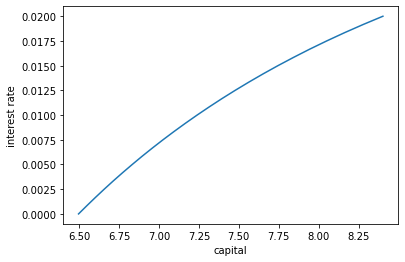

In [15]:
M = 25
r_vals = np.linspace(0, 0.02, M)
fig, ax = plt.subplots()

asset_mean = []
for r in r_vals:
    print(f'Solving model at r = {r}')
    ifp = IFP(r=r)
    mean = np.mean(compute_asset_series(ifp, T=250_000))
    asset_mean.append(mean)
ax.plot(asset_mean, r_vals)

ax.set(xlabel='capital', ylabel='interest rate')

plt.show() # (**Issue: no prints in both myst and origin**)

As expected, aggregate savings increases with the interest rate.